In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *
print(torch.cuda.is_available())

False


### Bivariate Normal Data Generation

In [3]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 5],
    2: [3, 1],
    3: [1.5, 6]
}
std = 0.3
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

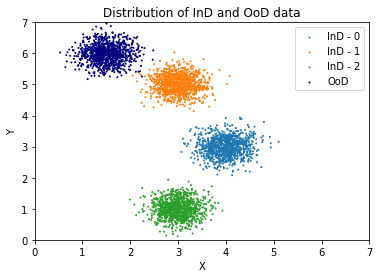

In [4]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

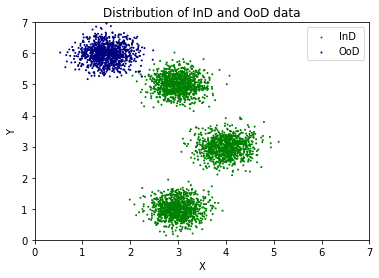

In [5]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [ ]:
from tqdm import tqdm
from simulation import classifier_training, DSIM_SINGLE, GSIM_SINGLE
D = DSIM(128)
# D = DSIM_SINGLE()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

### WOOD Training

#### Check sampled points

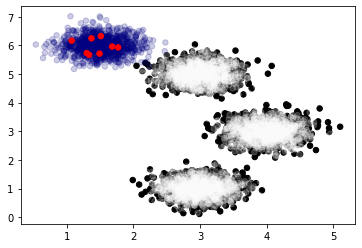

In [84]:
n_ood = 8
ood_bsz = 4
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
plt.scatter(IND_X[:,0], IND_X[:,1], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='red', label="OoD", sizes=[30]*len(OOD_X), alpha=1)

#### Training

In [ ]:
from simulation import *
D_WOOD = DSIM(128).to(DEVICE)
# D_WOOD = DSIM_SINGLE()
# OOD data preparation
ood_bsz = 4
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
beta = 1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

In [12]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 1.0
0.99: 0.9980000257492065
0.999: 0.972000002861023


0.0025662347576582917

### OOD GAN Training

In [ ]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(128).to(DEVICE)
G_GAN = GSIM(128).to(DEVICE)
# D_GAN = DSIM_SINGLE(64)
# G_GAN = GSIM_SINGLE(64)
# OOD data preparation
ood_bsz = 4
bsz_tri = 32
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-4
w_ce, w_wass, w_dist = 1, 1, 1
scaling = 0.01
d_step_ratio, g_step_ratio = 3, 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist, scaling,\
                    d_step_ratio, g_step_ratio, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=50)

### PLOT

In [44]:
from simulation import plot_heatmap
n_ind, n_ood = 25, 15
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)

#### Plot Naive Classifier

In [ ]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D, "NAIVE", ind_idx, ood_idx, 100)

#### Plot WOOD

0.99: 0.9980000257492065
Rejection Threshold: 0.0001065497635863697
Rejection Region Proportion: 35.18%


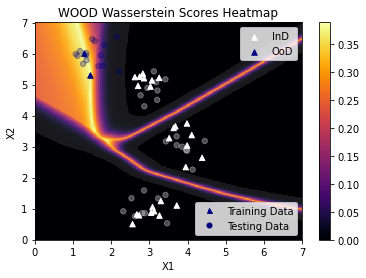

In [48]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_WOOD, None, "WOOD", ind_idx, ood_idx, m=400)

In [ ]:
# plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
# cbar = plt.colorbar(ticks=list(np.arange(0.05, 0.4, 0.05)) + [threshold], orientation='vertical')
# str_label = [f"{x:.2f}" for x in list(np.round(np.arange(0.05, 0.4, 0.05), 2))] + ['T']
# cbar.ax.set_yticklabels(str_label) 

#### Plot GAN

torch.Size([160000, 3])
0.99: 0.9980000257492065
Rejection Region Proportion: 36.22%


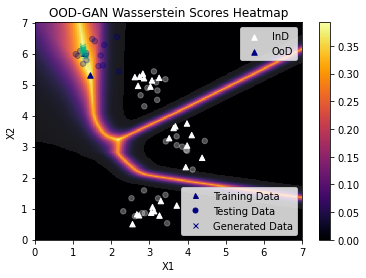

In [47]:
from simulation import plot_heatmap
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_GAN, G_GAN, "OOD-GAN", ind_idx, ood_idx, m=400)

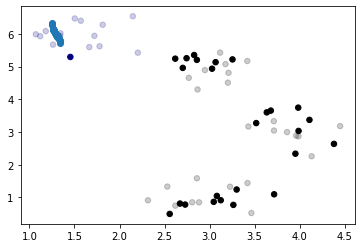

In [45]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='black', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Naive Augmentation on WOOD

### Distributional Shift

In [72]:
z_ind = torch.softmax(D_WOOD(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
s_ind = ood_wass_loss(z_ind)
# print(threshold)
z_ood = torch.softmax(D_WOOD(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
s_ood = ood_wass_loss(z_ood)

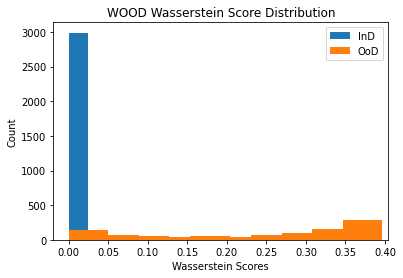

In [73]:
plt.hist(s_ind,width=0.025, label='InD')
plt.hist(s_ood,width=0.05, label='OoD')
plt.title("WOOD Wasserstein Score Distribution")
plt.xlabel("Wasserstein Scores")
plt.ylabel("Count")
plt.legend()
plt.savefig("../Notebooks/simulation_log/plot/WOOD-hist.jpg", dpi=1000)

#### GAN

In [69]:
z_ind = torch.softmax(D_GAN(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
s_ind = ood_wass_loss(z_ind)
z_ood = torch.softmax(D_GAN(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
s_ood = ood_wass_loss(z_ood)

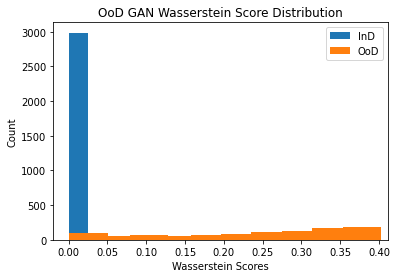

In [71]:
plt.hist(s_ind,width=0.025, label='InD')
plt.hist(s_ood,width=0.05, label='OoD')
plt.title("OoD GAN Wasserstein Score Distribution")
plt.xlabel("Wasserstein Scores")
plt.ylabel("Count")
plt.legend()
plt.savefig("../Notebooks/simulation_log/plot/OoD-GAN-hist.jpg", dpi=1000)

### Save

In [81]:
torch.save(D.state_dict(), "simulation_log/example/D.pt")
torch.save(D_WOOD.state_dict(), "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN.state_dict(), "simulation_log/example/D_GAN.pt")
torch.save(G_GAN.state_dict(), "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')
torch.save((ind_idx, ood_idx), 'simulation_log/example/plot_idx.pt')